# **Data Augmentation**

In [2]:
import pickle,gzip,math,os,time,shutil, random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torch
from torch import nn, distributions
from torch.nn import init
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

import fastcore.all as fc
from fastcore.test import test_close

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8 # since there is a ton of data augmentation in this NB

## **Setup**

In [11]:
xl, yl = 'image', 'labels'
name = "fashion_mnist"
bs = 1024
x_mean, x_std = 0.28, 0.35 # ref NB 11 initializing

@inplace
def transformi(b): b[xl]= [(TF.to_tensor(o) - x_mean)/ x_std for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [12]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [13]:
set_seed(42)
lr, epochs = 6e-2, 5

## **Going Wider Than Before**

The previous NB's ResNets were pretty basic and we didn't put a whole lot of thought into them. Let's attempt to make new networks which are wider than before by increasing the number of channels / filters to 512, whereas we limited the previous networks to 256.

We can do this by increasing our kernel size `ks` to 5 and changing the `stride` to 1, which will give us a 5x5 grid of 25 inputs. So we can increase the number of ouputs to 16 instead of 8. By starting with 16 outputs, and doubling with each layer, we will get 512 outputs.

In [14]:
def get_model(act=nn.ReLU, nfs=(16, 32, 64, 128, 256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1 )]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [15]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.825,0.704,0,train
0.860,0.508,0,eval
0.898,0.380,1,train
0.884,0.373,1,eval
0.921,0.267,2,train
0.905,0.293,2,eval
0.943,0.193,3,train
0.927,0.235,3,eval
0.963,0.137,4,train
0.930,0.222,4,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


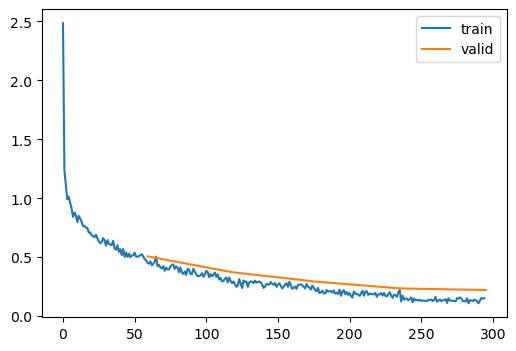

In [16]:
learn.fit(epochs)